# Convolve Theory by Window

Import some modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mcfit
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from nbodykit.cosmology.correlation import pk_to_xi, xi_to_pk

In [2]:
plt.rc('font', size=20)

## Define some functions

* RSD    : model the linear RSD
* Ps2Xis : takes P0, P2,... and outputs Xi0, ... of the theory
* convolve_xi_window : convolves the theory Xis and Windows W(r)s
* Xi2Ps : Transform the convolved theory Xi to P

In [3]:
def RSD(P, b=1.0, f=0.7):
    ''' Linear RSD '''
    P0 = (b*b + 2/3 * b* f + 0.2*f*f)*P
    P2 = (4/3*b*f + 4/7 * f*f )*P
    P4 = (8/35*f*f)*P
    return P0, P2, P4
    
def Ps2Xis(R, K, P0, P2, P4):
    #R = np.linspace(0, 200)
    Xi0 = pk_to_xi(K, P0, ell=0, extrap=True)(R)
    Xi2 = pk_to_xi(K, P2, ell=2, extrap=True)(R)
    Xi4 = pk_to_xi(K, P4, ell=4, extrap=True)(R)
    return R, Xi0, Xi2, Xi4

def convolve_xi_window(Xi0, Xi2, Xi4,
                      W0, W2, W4, W6=0.0, W8=0.0):
    WW0  = W0*W0
    WW2  = W2*W2
    WW4  = W4*W4
    WW6  = W6*W6
    WW8  = W8*W8
    
    Xiw0 = Xi0*WW0 + 0.2*Xi2*WW2 + 1./9.*Xi4*WW4
    Xiw2 = Xi0*WW2 + Xi2*(WW0 + 2./7.*WW2 + 2./7.*WW4)\
                   + Xi4*(2/7*WW2 + 100/693*WW4 + 25/143*WW6)
    Xiw4 = Xi0*WW4 + Xi2*(18/35*WW2 + 20/77*W4*W4 + 45/143*WW6)\
                   + Xi4*(WW0 + 20/77*WW2 + 162/1001*WW4+ 20/143*WW6 + 490/2431*WW8) 
    return Xiw0, Xiw2, Xiw4

def Xis2Pis(K, R, Xiw0, Xiw2, Xiw4):
    Pw0 = xi_to_pk(R, Xiw0, ell=0, extrap=True)(K)
    Pw2 = xi_to_pk(R, Xiw2, ell=2, extrap=True)(K)
    Pw4 = xi_to_pk(R, Xiw4, ell=4, extrap=True)(K)
    return K, Pw0, Pw2, Pw4

In [4]:
# theory K, P(k)
Klin, Plin = np.loadtxt('PklinPlanck15.dat').T
K = np.logspace(np.log10(Klin.min()), np.log10(Klin.max()), Klin.size)
P = IUS(Klin, Plin, k=5)(K)

R = np.logspace(np.log10(0.0001), np.log10(5000), num=1000)

# read the window W0, ... from Florian's
Rw, W0i, W2i, W4i = np.loadtxt('./Wr_ell.txt').T
fc  = W0i[0]
W0i /= fc
W2i /= fc
W4i /= fc
W0  = IUS(Rw, W0i)(R)
W2  = IUS(Rw, W2i)(R)
W4  = IUS(Rw, W4i)(R)


# Compute the multipoles of the theory P(k)
P0, P2, P4       = RSD(P, b=1, f=0.7)

# transform to Xi
R, Xi0, Xi2, Xi4 = Ps2Xis(R, K, P0, P2, P4)

# Multiply Window
Xiw0, Xiw2, Xiw4 = convolve_xi_window(Xi0, Xi2, Xi4, W0, W2, W4) 

# transform to P
K, Pw0, Pw2, Pw4 = Xis2Pis(K, R, Xiw0, Xiw2, Xiw4)

In [27]:
K, P0f, P2f, P4f = Xis2Pis(K, R, Xi0, Xi2, Xi4)

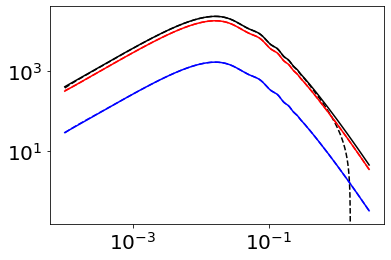

In [29]:
c = ['k', 'r', 'b']
for i, (a,b) in enumerate(zip([P0, P2, P4], [P0f, P2f, P4f])):
    plt.loglog(K, a, ls='-', c=c[i])
    plt.loglog(K, b, ls='--', c=c[i])

Let's look at the theoretical multipoles before and after convolution

Text(0.5, 0, 'r')

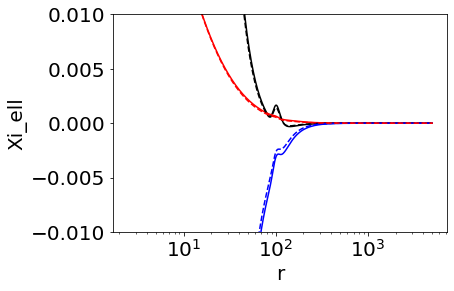

In [24]:
m = R >2.45
plt.plot(R[m], Xi0[m], 'k-',
         R[m], Xi2[m], 'b-',
         R[m], Xi4[m], 'r-',
         R[m], Xiw0[m], 'k--',
         R[m], Xiw2[m], 'b--',
         R[m], Xiw4[m], 'r--')
plt.ylim(-0.01,0.01)
plt.ylabel('Xi_ell')
plt.xscale('log')
plt.xlabel('r')

Let's change the y-axis range

Text(0.5, 0, 'r')

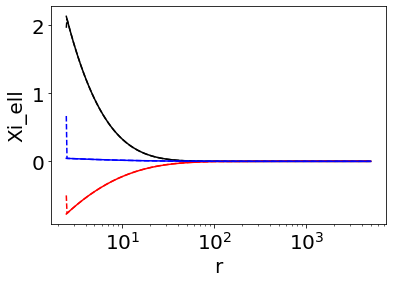

In [34]:
m = R>2.45

c = ['k', 'r', 'b']
for i, (a,b) in enumerate(zip([Xi0, Xi2, Xi4], [Xiw0, Xiw2, Xiw4])):
    plt.plot(R[m], a[m], ls='-', c=c[i])
    plt.plot(R[m], b[m], ls='--', c=c[i])
    
# plt.ylim(-0.01, 0.01)
plt.xscale('log')
plt.ylabel('Xi_ell')
plt.xlabel('r')

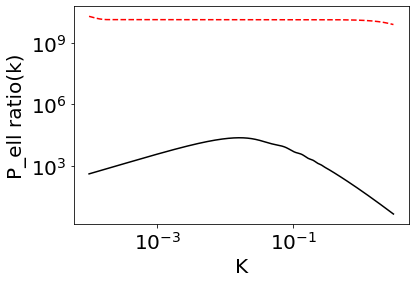

In [26]:
plt.plot(K, P0, 'k-',
         K, Pw0, 'r-',
         K, -Pw0, 'r--')
        #K, Pw2, 'b--',
        #K, Pw4, 'r--')
plt.ylabel('P_ell ratio(k)')
plt.xlabel('K')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(-100, 100)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(2.e-5, 5.e0)
#plt.ylim(1.e-1, 1.e5)
#plt.xscale('log')